In [10]:
#lets import the usual suspects
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#other imports we will be needing in this notebook
import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types
from pyspark.sql.functions import col, isnan, when, count

from pyspark.ml.feature import Imputer, VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier 
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

warnings.filterwarnings('ignore')

In [11]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

## Data Preparation 

In [12]:
fullpath = 'WOW_Google_Analytics_final.csv'

In [13]:
# read.csv is very similar to the Pandas version
data = spark.read.csv(fullpath,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Medium: string (nullable = true)
 |-- Exits: integer (nullable = true)
 |-- Pageviews: integer (nullable = true)
 |-- Session Duration: integer (nullable = true)
 |-- Sessions: integer (nullable = true)
 |-- TimeOnPage: integer (nullable = true)
 |-- Unique Pageviews: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Bounces: integer (nullable = true)
 |-- CountOfDays: string (nullable = true)



In [5]:
data.show(5)

+-------+-------+-------+--------+-----+---------+----------------+--------+------------+----------------+-----+----+-------+
|Country|    Day|Source |  Medium|Exits|Pageviews|Session Duration|Sessions|Time on Page|Unique Pageviews|Month|Year|Bounces|
+-------+-------+-------+--------+-----+---------+----------------+--------+------------+----------------+-----+----+-------+
|Unknown| Sunday|direct |    none|    2|        4|             167|       2|         167|               4|   12|2019|      0|
|Unknown| Monday|direct |    none|    2|       10|             668|       2|         669|               5|   12|2019|      0|
|Unknown| Monday|google | organic|    1|        1|               0|       1|           0|               1|   12|2019|      1|
|Unknown|Tuesday|direct |    none|    1|       27|            3741|       1|        3741|              11|   12|2019|      0|
|Unknown|Tuesday|google | organic|    1|        1|               0|       1|           0|               1|   12|2019| 

In [6]:
data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-------+---+-------+-------+-----+---------+----------------+--------+------------+----------------+-----+----+-------+
|Country|Day|Source | Medium|Exits|Pageviews|Session Duration|Sessions|Time on Page|Unique Pageviews|Month|Year|Bounces|
+-------+---+-------+-------+-----+---------+----------------+--------+------------+----------------+-----+----+-------+
|      0|  0|      0|      0|    0|        0|               0|       0|           0|               0|    0|   0|      0|
+-------+---+-------+-------+-----+---------+----------------+--------+------------+----------------+-----+----+-------+



## Data Preprocessing 

### 1- Cleaning the data 

In [7]:
#convert to pandas
df = data.toPandas()

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33865 entries, 0 to 33864
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           33865 non-null  object
 1   Day               33865 non-null  object
 2   Source            33865 non-null  object
 3    Medium           33865 non-null  object
 4   Exits             33865 non-null  int32 
 5   Pageviews         33865 non-null  int32 
 6   Session Duration  33865 non-null  int32 
 7   Sessions          33865 non-null  int32 
 8   Time on Page      33865 non-null  int32 
 9   Unique Pageviews  33865 non-null  int32 
 10  Month             33865 non-null  int32 
 11  Year              33865 non-null  int32 
 12  Bounces           33865 non-null  int32 
dtypes: int32(9), object(4)
memory usage: 2.2+ MB


#### First,
the dataset is from 2019 - 2021, however, we have only 5 records that is in 2019 so we decided on dropping them to keep our analysis for only 2020 and 2021.

In [9]:
df.drop(df.index[:5], inplace=True)

In [10]:
# now our dataset start from 2020. 
df.head(5)

,Country,Day,Source,Medium,Exits,Pageviews,Session Duration,Sessions,Time on Page,Unique Pageviews,Month,Year,Bounces
5,Unknown,Friday,direct,none,2,6,282,2,282,5,1,2020,0
6,Unknown,Tuesday,direct,none,1,1,0,1,0,1,1,2020,1
7,Unknown,Wednesday,direct,none,2,4,54,2,55,4,1,2020,1
8,Unknown,Wednesday,google,organic,1,3,35,1,35,3,1,2020,0
9,Unknown,Wednesday,twitter,referral,1,3,761,1,761,2,1,2020,0


#### Second,
we had two columns with spaces so we need to rename them.

In [11]:
df.rename(columns = {'Source ':'Source', ' Medium': 'Medium' , 'Time on Page' : 'TimeOnPage'}, inplace = True)

In [12]:
# checking again
df.columns

Index(['Country', 'Day', 'Source', 'Medium', 'Exits', 'Pageviews',
       'Session Duration', 'Sessions', 'TimeOnPage', 'Unique Pageviews',
       'Month', 'Year', 'Bounces'],
      dtype='object')

#### Third,
we want to create new columns to count the number of days people have spent to solve the challenges we want to understand what possibly can cause people to submit lately.

In [13]:
def Day_Counts(day):
    
    if day == 'Wednesday':
        return "Challenge Day Traffic"
    elif day == 'Thursday':
        return "One Day After"
    elif day == 'Friday':
        return "Two Day After"
    elif day == 'Saturday':
        return "Solution Day Traffic"
    else:
        return "After Solution Day"

In [14]:
df['CountOfDays'] = df['Day'].map(Day_Counts)

In [15]:
# checking our dataset. 
df.head(5)

,Country,Day,Source,Medium,Exits,Pageviews,Session Duration,Sessions,TimeOnPage,Unique Pageviews,Month,Year,Bounces,CountOfDays
5,Unknown,Friday,direct,none,2,6,282,2,282,5,1,2020,0,Two Day After
6,Unknown,Tuesday,direct,none,1,1,0,1,0,1,1,2020,1,After Solution Day
7,Unknown,Wednesday,direct,none,2,4,54,2,55,4,1,2020,1,Challenge Day Traffic
8,Unknown,Wednesday,google,organic,1,3,35,1,35,3,1,2020,0,Challenge Day Traffic
9,Unknown,Wednesday,twitter,referral,1,3,761,1,761,2,1,2020,0,Challenge Day Traffic


In [16]:
print(df['Day'].value_counts().nlargest(7))
print('--------------------------------------------')
print(df['CountOfDays'].value_counts().nlargest(7))

Wednesday    5964
Tuesday      5805
Thursday     5228
Monday       5006
Friday       4528
Sunday       3904
Saturday     3425
Name: Day, dtype: int64
--------------------------------------------
After Solution Day       14715
Challenge Day Traffic     5964
One Day After             5228
Two Day After             4528
Solution Day Traffic      3425
Name: CountOfDays, dtype: int64


#### Lastly,
we created a second df for the visualization part, we removed the 'unkown' value of Country and the 'non' value of Medium but after adding the new column.

In [17]:
# for visualization - Norah
df2 = df
df2 = df2[(df.Country != 'Unknown') & (df.Medium != 'none')]
df2.head(5)

,Country,Day,Source,Medium,Exits,Pageviews,Session Duration,Sessions,TimeOnPage,Unique Pageviews,Month,Year,Bounces,CountOfDays
373,Afghanistan,Sunday,google,organic,1,1,0,1,0,1,11,2020,1,After Solution Day
374,Afghanistan,Friday,google,organic,1,1,0,1,0,1,11,2020,1,Two Day After
375,Afghanistan,Saturday,google,organic,1,1,0,1,0,1,11,2020,1,Solution Day Traffic
376,Afghanistan,Wednesday,google,organic,2,2,0,2,0,2,12,2020,2,Challenge Day Traffic
377,Afghanistan,Saturday,google,organic,1,1,0,1,0,1,12,2020,1,Solution Day Traffic


In [19]:
df2.to_csv('WOW_Google_Analytics_final_vis.csv')

## Exploratory Data Analysis (EDA)


In [20]:
fullpath = 'WOW_Google_Analytics_final_vis.csv'

In [3]:
# read.csv is very similar to the Pandas version
data = spark.read.csv(fullpath,
                     sep=',',
                     inferSchema=True,
                     header=True,
                     multiLine=True)

data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Medium: string (nullable = true)
 |-- Exits: integer (nullable = true)
 |-- Pageviews: integer (nullable = true)
 |-- Session Duration: integer (nullable = true)
 |-- Sessions: integer (nullable = true)
 |-- TimeOnPage: integer (nullable = true)
 |-- Unique Pageviews: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Bounces: integer (nullable = true)
 |-- CountOfDays: string (nullable = true)



In [14]:
data = data.drop(data._c0)
data.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Day: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Medium: string (nullable = true)
 |-- Exits: integer (nullable = true)
 |-- Pageviews: integer (nullable = true)
 |-- Session Duration: integer (nullable = true)
 |-- Sessions: integer (nullable = true)
 |-- TimeOnPage: integer (nullable = true)
 |-- Unique Pageviews: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Bounces: integer (nullable = true)
 |-- CountOfDays: string (nullable = true)



### Descriptive Statistics

* We will get descriptive statistics for Pageviews, Sessions,Time on Page, Unique Pageviews,and Year to see how these data are distributed.

In [40]:
#The descriptive statistics for numerical columns 
data.select('Pageviews','Sessions','TimeOnPage','Unique Pageviews','Year').summary().show()

+-------+------------------+-----------------+------------------+------------------+------------------+
|summary|         Pageviews|         Sessions|      Time On Page|  Unique Pageviews|              Year|
+-------+------------------+-----------------+------------------+------------------+------------------+
|  count|             33492|            33492|             33492|             33492|             33492|
|   mean|12.110653290337991|4.637256658306462|1051.6415561925237| 9.290517138421116| 2020.295861698316|
| stddev|28.889658031782545|10.66035593457974|2781.1514220959184|21.757156059216733|0.4653118058133749|
|    min|                 0|                1|                 0|                 0|              2019|
|    25%|                 1|                1|                 0|                 1|              2020|
|    50%|                 3|                2|                69|                 3|              2020|
|    75%|                10|                4|               833

* We will get descriptive statistics for Country, Day,Source, Medium,and CountOfDays to see how these data are distributed.

In [41]:
#The descriptive statistics for categorical columns 
data.select('Country','Day','Source','Medium','CountOfDays').summary().show()

+-------+-----------+---------+-----------------+------+------------------+
|summary|    Country|      Day|           Source|Medium|       CountOfDays|
+-------+-----------+---------+-----------------+------+------------------+
|  count|      33492|    33492|            33492| 33492|             33492|
|   mean|       null|     null|             null|  null|              null|
| stddev|       null|     null|             null|  null|              null|
|    min|Afghanistan|   Friday|Revue newsletter | email|After Solution Day|
|    25%|       null|     null|             null|  null|              null|
|    50%|       null|     null|             null|  null|              null|
|    75%|       null|     null|             null|  null|              null|
|    max|   Zimbabwe|Wednesday|            zalo |  zalo|     Two Day After|
+-------+-----------+---------+-----------------+------+------------------+



### 2- Data Exploration

In [42]:
#Total of Country
data.registerTempTable('data')

Country_counts = spark.sql(r"""SELECT Country, COUNT(Country) AS total 
                                     FROM data 
                                     GROUP BY Country 
                                     ORDER BY total desc """)
Country_counts.show()

+--------------+-----+
|       Country|total|
+--------------+-----+
| United States| 3750|
|         India| 2233|
|United Kingdom| 1947|
|         Japan| 1620|
|        Canada| 1470|
|     Australia| 1370|
|     Singapore| 1214|
|       Germany| 1012|
|        France|  885|
|   Netherlands|  851|
|         China|  848|
|         Italy|  807|
|        Taiwan|  801|
|        Poland|  666|
|         Spain|  625|
|       Ireland|  521|
|        Mexico|  516|
|   South Korea|  480|
|        Russia|  471|
|       Vietnam|  469|
+--------------+-----+
only showing top 20 rows



In [43]:
#Total of Source
data.registerTempTable('data')

Source_counts = spark.sql(r"""SELECT Source, COUNT(Source) AS total 
                                     FROM data 
                                     GROUP BY Source 
                                     ORDER BY total desc """)
Source_counts.show()

+-------------+-----+
|       Source|total|
+-------------+-----+
|      direct |10875|
|      google |10579|
|      twitter| 3039|
|      tableau| 2753|
|      youtube|  969|
|        bing |  781|
|    pinterest|  663|
|       reddit|  569|
|       medium|  391|
|     facebook|  326|
|     linkedin|  313|
|       vizwiz|  259|
|        baidu|  206|
|       google|  185|
|       baidu |  179|
|       yahoo |  177|
|  duckduckgo |  132|
|        yahoo|   79|
|tableau magic|   78|
|       yammer|   69|
+-------------+-----+
only showing top 20 rows



### 3- EDA

### First Plot, Count Plot of Country
* Let's see the Count Of Country that visit the challenges.

In [51]:
#First we select the subset of data using SQL 
df_vis = spark.sql('SELECT Country FROM data WHERE Country IN ("United States","India","United Kingdom","Japan","Canada")')

#Seconde we convert it to a pandas dataframe
df_vis = df_vis.toPandas()

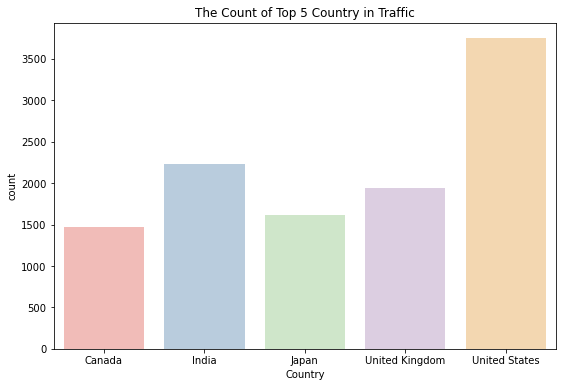

In [52]:
#Count Plot of Country
plt.figure(figsize=(9,6))
sns.countplot(x='Country',data=df_vis, palette='Pastel1')
plt.title('The Count of Top 5 Country in Traffic')
plt.show()

### Insight, 

- As we see, United States has the most number of share in these challenges, followed by India, United Kingdom, Japan and Canada.

### Second Plot, Count Plot of Days
* Let's see the Count Of Days.

In [46]:
#First we select the subset of data using SQL 
df_vis = spark.sql('SELECT Day FROM data')

#Seconde we convert it to a pandas dataframe
df_vis = df_vis.toPandas()#Count Plot of Country

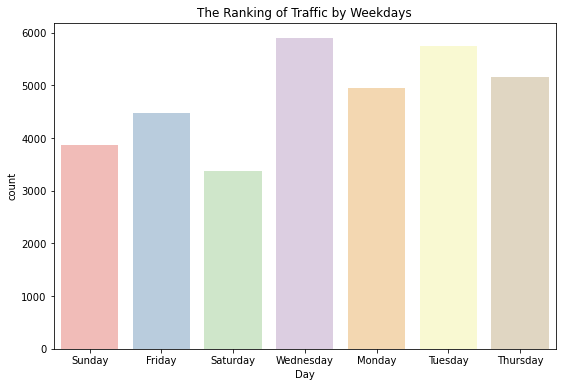

In [47]:
#Count Plot of Country
plt.figure(figsize=(9,6))
sns.countplot(x='Day',data=df_vis, palette='Pastel1')
plt.title('The Ranking of Traffic by Weekdays')
plt.show()

### Insight, 
- As we see, the traffic is higher in Wednesday because it's the day when the challenge is released. 

### Third Plot, Pie Chart of Count Of Days
* Let's see the percentage of each Count Of Days in the website.

In [81]:
#First we select the subset of data using SQL 
df_vis = spark.sql('SELECT CountOfDays FROM data')

#Seconde we convert it to a pandas dataframe
df_vis = df_vis.toPandas()

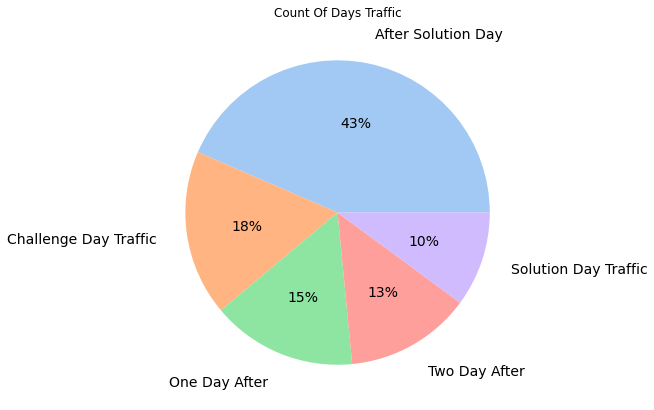

In [82]:
#Pie Chart of CountOfDays
df_vis_c = df_vis['CountOfDays'].value_counts().nlargest(5) 
colors = sns.color_palette('pastel')
plt.figure(figsize=(7,7))
plt.pie(df_vis_c.values, labels=df_vis_c.index, colors=colors, autopct='%.0f%%',labeldistance=1.2,textprops={'fontsize': 14})
plt.title('Count Of Days Traffic')
plt.show()

### Insight, 
- As we see, The 43% of users Passed Solution Day , 18% Same Day Submission , 15% One Day After , 13% Two Day After and 10% Solution Day Submission.

### Fourth Plot, Scatter Plot of CountOfDays vs TimeOnPage and Pageviews
* Let's see the Relationship between these columns.

In [7]:
data.show(5)

+-----------+---------+-------+--------+-----+---------+----------------+--------+----------+----------------+-----+----+-------+--------------------+
|    Country|      Day| Source|  Medium|Exits|Pageviews|Session Duration|Sessions|TimeOnPage|Unique Pageviews|Month|Year|Bounces|         CountOfDays|
+-----------+---------+-------+--------+-----+---------+----------------+--------+----------+----------------+-----+----+-------+--------------------+
|Afghanistan|   Sunday|google | organic|    1|        1|               0|       1|         0|               1|   11|2020|      1| Passed Solution Day|
|Afghanistan|   Friday|google | organic|    1|        1|               0|       1|         0|               1|   11|2020|      1|       Two Day After|
|Afghanistan| Saturday|google | organic|    1|        1|               0|       1|         0|               1|   11|2020|      1|Solution Day Subm...|
|Afghanistan|Wednesday|google | organic|    2|        2|               0|       2|         0| 

In [18]:
#First we select the subset of data using SQL 
df_vis = spark.sql(r"""SELECT CountOfDays, Pageviews, TimeOnPage FROM data""")

#Seconde we convert it to a pandas dataframe
df_vis = df_vis.toPandas()

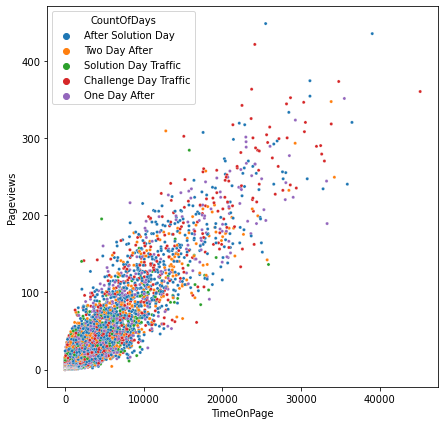

In [21]:
plt.figure(figsize=(7,7))
##scatter Plot of CountOfDays , TimeOnPage , Pageviews
ax = sns.scatterplot(data=df_vis, x='TimeOnPage', y='Pageviews', hue='CountOfDays', s=10)

### Fifth Plot, Pair Plot for some numerical values with target 'CountOfDays'
* Let's see the relationship between these columns and targets.

In [174]:
#First we select the subset of data using SQL 
df_vis = spark.sql('SELECT CountOfDays, Pageviews, Sessions, TimeOnPage FROM data')

#Seconde we convert it to a pandas dataframe
df_v#PairPlot for some numerical values with target'CountOfDays'
sns.pairplot(df_vis, kind='reg', hue='CountOfDays', corner=True, size=5)is = df_vis.toPandas()

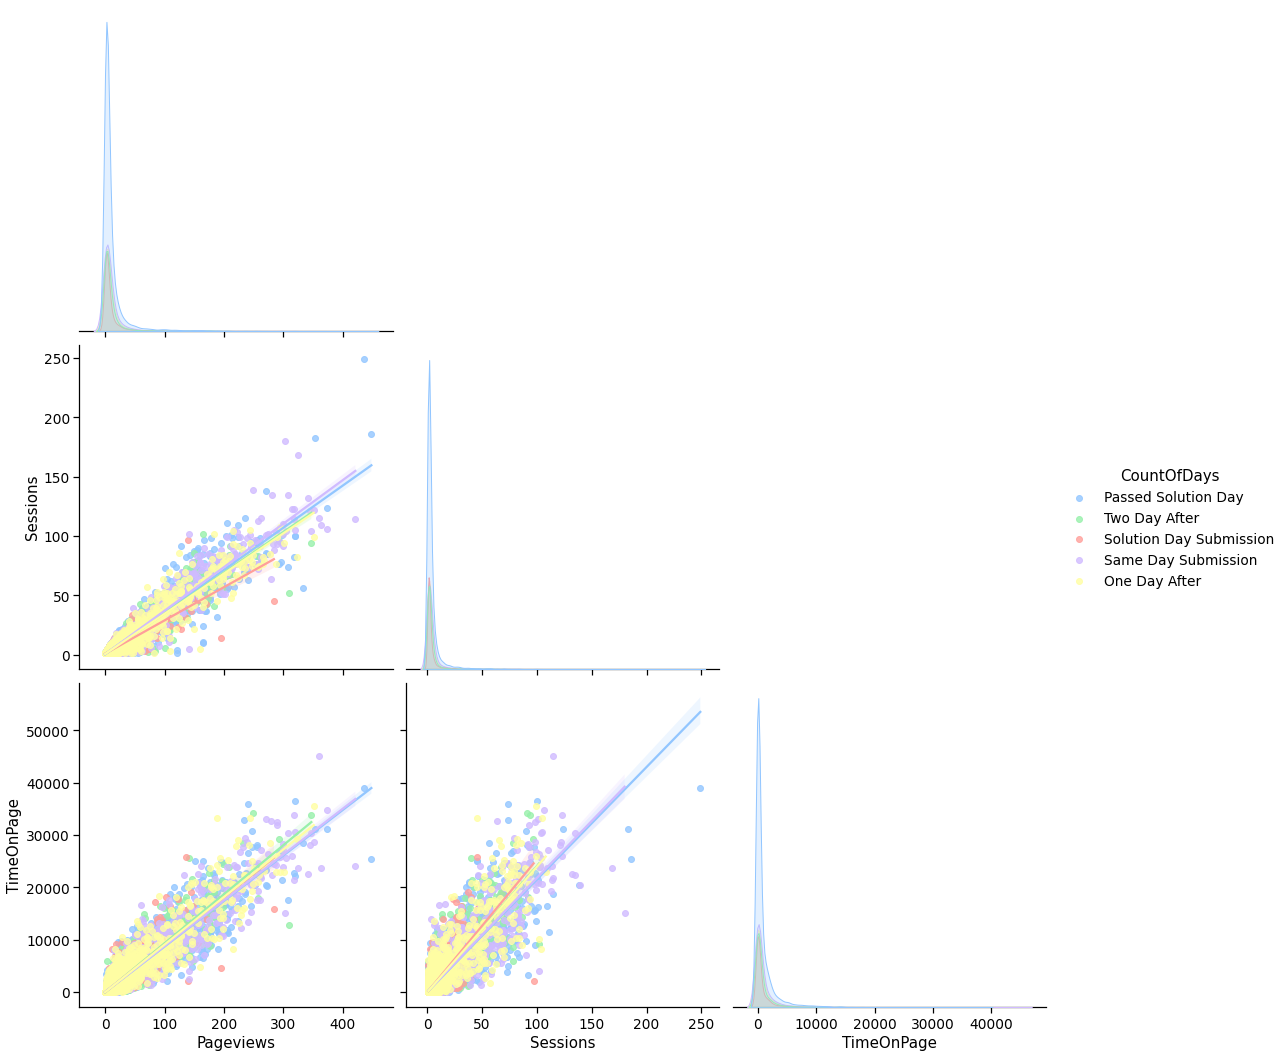

In [175]:
#PairPlot for some numerical values with target'CountOfDays'
sns.pairplot(df_vis, kind='reg', hue='CountOfDays', corner=True, size=5)

#### Pageviews vs TimeOnPage < regression lines>,
#### Pageviews vs Sessions < regression lines>,
#### Sessions vs TimeOnPage < regression lines>,
#### All have Strong Correlation with Count of Days.

## Data Processing

### Feature Selection and Tranformation

In [145]:
#converting the dataframe to Spark df
sparkdf = spark.createDataFrame(df) 

In [146]:
# indexing our categorical cols
cat_cols = ['Country', 'Source', 'Medium', 'CountOfDays' , 'Day'] 

for col in cat_cols:
    label_stringIdx = StringIndexer(inputCol = col, outputCol=col+'_idx')
    sparkdf = label_stringIdx.fit(sparkdf).transform(sparkdf)

    
sparkdf = sparkdf.drop(*cat_cols)    
sparkdf.show(2)

+-----+---------+----------------+--------+------------+----------------+-----+----+-------+-----------+----------+----------+---------------+-------+
|Exits|Pageviews|Session Duration|Sessions|Time on Page|Unique Pageviews|Month|Year|Bounces|Country_idx|Source_idx|Medium_idx|CountOfDays_idx|Day_idx|
+-----+---------+----------------+--------+------------+----------------+-----+----+-------+-----------+----------+----------+---------------+-------+
|    2|        6|             282|       2|         282|               5|    1|2020|      0|       28.0|       0.0|       1.0|            3.0|    4.0|
|    1|        1|               0|       1|           0|               1|    1|2020|      1|       28.0|       0.0|       1.0|            0.0|    1.0|
+-----+---------+----------------+--------+------------+----------------+-----+----+-------+-----------+----------+----------+---------------+-------+
only showing top 2 rows



In [147]:
#remove CountOfDays -> we need this to be our label
cols = sparkdf.columns
cols.remove('CountOfDays_idx')


#vector assembler will take all the columns and convert them into one column called features
assembler = VectorAssembler(inputCols=cols, outputCol="features")

#the .transform will apply the changes here
sparkdf = assembler.transform(sparkdf)

In [148]:
train, test = sparkdf.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 27051
Test Dataset Count: 6809


In [149]:
train.show(5)

+-----+---------+----------------+--------+------------+----------------+-----+----+-------+-----------+----------+----------+---------------+-------+--------------------+
|Exits|Pageviews|Session Duration|Sessions|Time on Page|Unique Pageviews|Month|Year|Bounces|Country_idx|Source_idx|Medium_idx|CountOfDays_idx|Day_idx|            features|
+-----+---------+----------------+--------+------------+----------------+-----+----+-------+-----------+----------+----------+---------------+-------+--------------------+
|    0|        0|               0|       1|           0|               0|    1|2020|      0|       19.0|       3.0|       2.0|            3.0|    4.0|(13,[3,6,7,9,10,1...|
|    0|        0|               0|       1|           0|               0|    1|2020|      0|       23.0|       0.0|       1.0|            1.0|    0.0|(13,[3,6,7,9,11],...|
|    0|        0|               0|       1|           0|               0|    1|2020|      0|       36.0|       1.0|       0.0|            3.

## Building a Model 

#### Random Forest Classifier

In [167]:
# Initializing the model 
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'CountOfDays_idx', maxBins = 170)

# fitting the model on train set 
rfModel = rf.fit(train)

# testing the model on test set 
rf_predictions = rfModel.transform(test)

In [168]:
# preds vs actual 
rf_predictions.select("CountOfDays_idx", "prediction").show(15)

+---------------+----------+
|CountOfDays_idx|prediction|
+---------------+----------+
|            0.0|       0.0|
|            0.0|       0.0|
|            0.0|       0.0|
|            0.0|       0.0|
|            0.0|       0.0|
|            2.0|       2.0|
|            2.0|       2.0|
|            2.0|       2.0|
|            0.0|       0.0|
|            1.0|       1.0|
|            1.0|       1.0|
|            0.0|       0.0|
|            4.0|       3.0|
|            0.0|       0.0|
|            3.0|       3.0|
+---------------+----------+
only showing top 15 rows



#### Decision Tree Classifier

In [175]:
# Initializing the model 
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'CountOfDays_idx', maxBins = 170)

# fitting the model on train set 
dtModel = rf.fit(train)

# testing the model on test set 
dt_predictions = dtModel.transform(test)

## Model Evaluation

In [176]:
### initialize the MulticlassClassification evaluator 
evaluator = MulticlassClassificationEvaluator(labelCol="CountOfDays_idx", predictionCol="prediction")

In [171]:
accuracy = evaluator.evaluate(rf_predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.8651267016299288
Test Error = 0.13487329837007123


In [172]:
accuracy = evaluator.evaluate(dt_predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.8651267016299288
Test Error = 0.13487329837007123


In [172]:
accuracy = evaluator.evaluate(gb_predictions)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.8651267016299288
Test Error = 0.13487329837007123


## Model Optimization

In [162]:
### initialize evaluator and grid

evaluator2 = MulticlassClassificationEvaluator(labelCol="CountOfDays_idx", predictionCol="prediction")
grid = ParamGridBuilder().build()

In [163]:
cv_rf = CrossValidator(estimator=rf, evaluator=evaluator2, estimatorParamMaps=grid, numFolds=5)
cv_model = cv_dt.fit(train)
predictions_cv = cv_model.transform(test)

In [164]:
predictions_cv.select("CountOfDays_idx", "prediction").show(15)

+---------------+----------+
|CountOfDays_idx|prediction|
+---------------+----------+
|            0.0|       0.0|
|            0.0|       0.0|
|            0.0|       0.0|
|            0.0|       0.0|
|            0.0|       0.0|
|            2.0|       2.0|
|            2.0|       2.0|
|            2.0|       2.0|
|            0.0|       0.0|
|            1.0|       1.0|
|            1.0|       1.0|
|            0.0|       0.0|
|            4.0|       3.0|
|            0.0|       0.0|
|            3.0|       3.0|
+---------------+----------+
only showing top 15 rows



In [166]:
accuracy = evaluator2.evaluate(predictions_cv)
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

Accuracy = 0.8651267016299288
Test Error = 0.13487329837007123
